In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import sqlite3
import pandas as pd
import networkx as nx
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

# Importando dados e criando network 

In [2]:
DATABASE = 'hw1_test.sqlite'
papers = []
authors = []
conn = sqlite3.connect(DATABASE,timeout=10)
for row in conn.execute('SELECT * FROM paper'):
    papers.append({'id':row[0],'paper_name':row[1]})
conn.close()

conn = sqlite3.connect(DATABASE,timeout=10)
for row in conn.execute('SELECT * FROM author'):
    authors.append({'id':row[0],'author_name':row[1]})
conn.close()

In [156]:
# Cria lista de arestas para rede de autores
query_pair_authors = """
SELECT paper_id,
       a1.author_id AS author1,
       a2.author_id AS author2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (paper_id)
WHERE a1.author_id < a2.author_id;
"""
conn = sqlite3.connect(DATABASE,timeout=10)
edges_authors = []
for row in conn.execute(query_pair_authors):
    edges_authors.append(row)
conn.close()
edges_authors= pd.DataFrame(edges_authors,dtype=int,columns=['paper','author1',
                                                             'author2']).applymap(lambda x: int(x))

# Cria lista de arestas para rede de papers
query_pair_papers = """
SELECT author_id,
       a1.paper_id AS paper1,
       a2.paper_id AS paper2
FROM author_paper AS a1
JOIN author_paper AS a2 USING (author_id)
WHERE a1.paper_id < a2.paper_id;
"""
conn = sqlite3.connect(DATABASE, timeout=10)
edges_papers = []
for row in conn.execute(query_pair_papers):
    edges_papers.append(row)
conn.close()
edges_papers = pd.DataFrame(edges_papers,columns=['author',
                                                  'paper1','paper2']).applymap(lambda x: int(x))


count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
count_papers  = edges_papers.groupby(['paper1','paper2']).count().reset_index()

edges_papers['author'] = edges_papers['author'].apply(lambda x: str(x)) 
count_papers  = edges_papers.groupby(['paper1','paper2']).agg(lambda x: ','.join(x)).reset_index()
# count_papers  = edges_papers.groupby(['paper1',
#' paper2']).agg({'author':[lambda x: ','.join(x),'count']}).reset_index()

count_papers['author'] = count_papers['author'].apply(lambda x: x.split(','))

In [158]:
count_papers['count'] = count_papers['author'].apply(lambda x: len(x))

In [165]:
query_pair_papers = """
SELECT  ap.paper_id, ap.author_id,
        a.author_name,
        p.paper_name
FROM author_paper AS ap
INNER JOIN author AS a ON ap.author_id = a.id
INNER JOIN paper AS p ON ap.paper_id = p.id
"""
conn = sqlite3.connect(DATABASE, timeout=10)
df = []
for row in conn.execute(query_pair_papers):
    df.append(row)
conn.close()

In [168]:
df = pd.DataFrame(df,columns=[''])
df.head()

,0,1,2,3
0,1,11,RS Targino,Sequential Monte Carlo samplers for capital al...
1,2,11,RS Targino,Understanding operational risk capital approxi...
2,3,11,RS Targino,Optimal exercise strategies for operational ri...
3,5,11,RS Targino,Full bayesian analysis of claims reserving unc...
4,6,11,RS Targino,Bayesian Approach for Parameter Estimation of ...


In [4]:
# Inserindo somente os nós e seus atributos

G_authors = nx.Graph()
G_papers = nx.Graph()

for d in authors: 
    node_id = d.pop('id')
    G_authors.add_node(node_id, **d) 
    
for d in papers: 
    node_id = d.pop('id')
    G_papers.add_node(node_id, **d) 

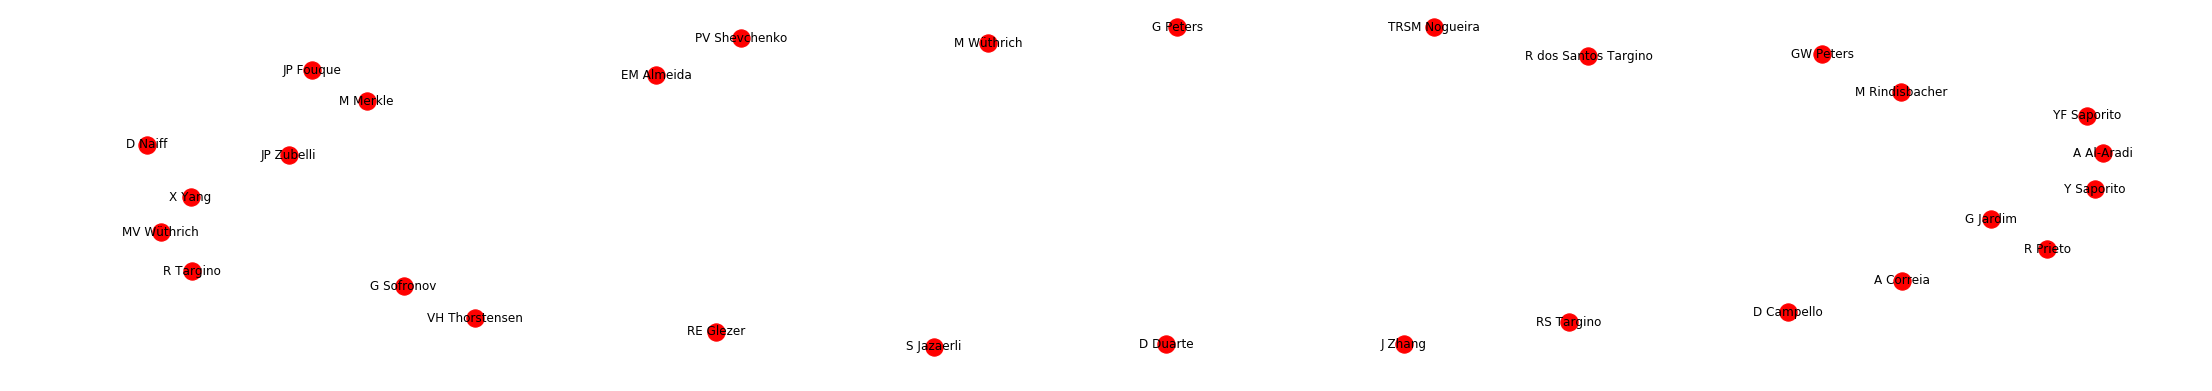

In [5]:
plt.figure(figsize=(30,5))
labels_author=dict((n,d['author_name']) for n,d in G_authors.nodes(data=True))
nx.draw_spring(G_authors,labels=labels_author,with_labels=True)

In [6]:
# Inserir as arestas
for d in count_authors.to_dict('records'):
    G_authors.add_edge(d['author1'],d['author2'],count = d['paper'])
    
for d in count_papers.to_dict('records'):
    G_papers.add_edge(d['paper1'],d['paper2'],count = d['author'])

/home/davi/Envs/datascience/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


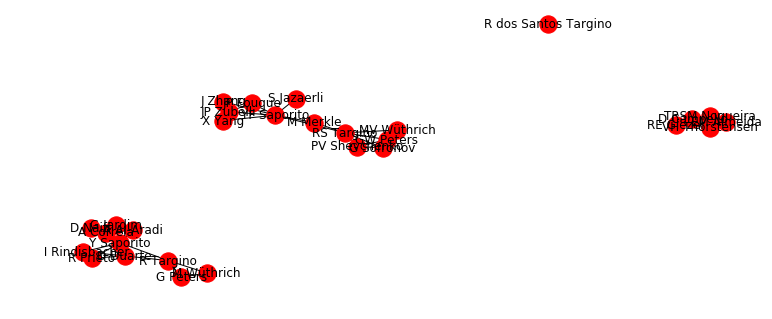

In [7]:
plt.figure(figsize=(10,4))
nx.draw_spring(G_authors,with_labels=True,labels=labels_author)

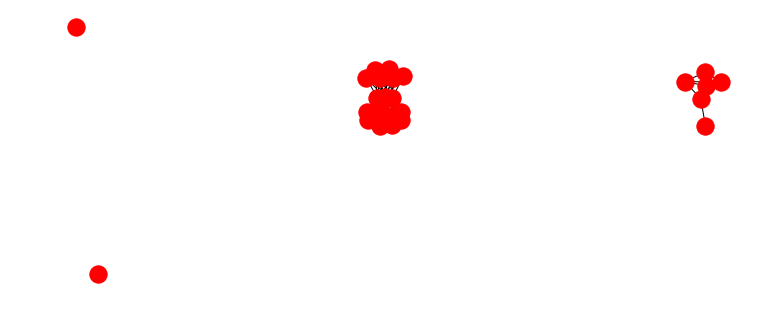

In [8]:
labels_paper =dict((n,d['paper_name']) for n,d in G_papers.nodes(data=True))
plt.figure(figsize=(10,4))
nx.draw_spring(G_papers,with_labels=False,labels=labels_paper)

# Utilizando Altair 
Para criar o grafo, precisamos de uma base de dados com as posições de cada nó, além de um índice para cada par.
Assim, iremos criar um plot para cada par, como se fosse uma categoria.

Vamos começar utilizando o repositório nx_altair

In [75]:
G_authors

In [61]:
#Obter a posicao de cada node
# df_authors = []
# pos = nx.spring_layout(G_authors,)
# for n in G_authors.nodes(data=True):
#     df_authors.append([n[0],n[1]['author_name'],pos[n[0]][0],pos[n[0]][1]])

In [62]:
from nx_altair import draw_networkx

,x,y,author_name
1,-0.38032,0.521899,D Duarte
2,-0.347144,0.311591,G Peters
3,-0.0409735,-0.749121,G Sofronov
4,0.0354195,-0.710432,GW Peters
5,-0.170632,-0.609938,M Merkle


Selection('selector063', SelectionDef({
  encodings: ['x', 'y'],
  type: 'multi'
}))


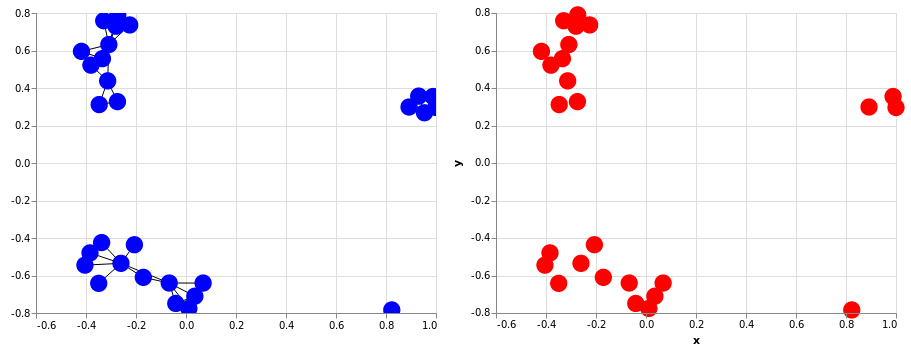

In [69]:
# Nota - Modifiquei o arquivo original do nx_altair para possibilitar plotar lado a lado
# O que foi removido foi o configure_axis da funcao
interval = alt.selection_multi(encodings=['x','y'])
brush    = alt.selection_multi(encodings=['x','y'])

pos = nx.spring_layout(G_authors)
chart_authors = draw_networkx(G_authors,pos,node_tooltip='author_name').interactive()

edges = chart_authors.layer[0]
nodes = chart_authors.layer[1].encode(
    fill = alt.condition(interval,alt.value('blue'),alt.value('lightgray')),
).properties(selection=interval)

chart_papers  = draw_networkx(G_papers,pos,node_tooltip='paper_name')
print(interval)
edges+nodes | chart_papers.layer[1]

In [15]:
def to_pandas_nodes(G, pos):
    """Convert Graph nodes to pandas DataFrame that's readable to Altair.
    """
    # Get all attributes in nodes
    attributes = ['x', 'y']
    for n in G.nodes():
        attributes += list(G.nodes[n].keys())
    attributes = list(set(attributes))

    # Build a dataframe for all nodes and their attributes
    df = pd.DataFrame(
        index=G.nodes(),
        columns=attributes
    )

    # Add node data to dataframe.
    for n in G.nodes:
        data = dict(
            x=pos[n][0],
            y=pos[n][1],
            **G.nodes[n]
        )
        df.loc[n] = data

    return df

def to_pandas_edges(G, pos, **kwargs):
    """Convert Graph edges to pandas DataFrame that's readable to Altair.
    """
    # Get all attributes in nodes
    attributes = ['source', 'target', 'x', 'y', 'edge', 'pair']
    for e in G.edges():
        attributes += list(G.edges[e].keys())
    attributes = list(set(attributes))


    # Build a dataframe for all edges and their attributes
    df = pd.DataFrame(
        index=range(G.size()*2),
        columns=attributes
    )


    # Add node data to dataframe.
    for i, e in enumerate(G.edges):
        idx = i*2

        data1 = dict(
            edge=i,
            source=e[0],
            target=e[1],
            pair=e,
            x=pos[e[0]][0],
            y=pos[e[0]][1],
            **G.edges[e]
        )

        data2 = dict(
            edge=i,
            source=e[0],
            target=e[1],
            pair=e,
            x=pos[e[1]][0],
            y=pos[e[1]][1],
            **G.edges[e]
        )

        df.loc[idx] = data1
        df.loc[idx+1] = data2

    return df

In [16]:
pos = nx.spring_layout(G_authors)
df_nodes_authors = to_pandas_nodes(G_authors,pos)
df_nodes_authors['author_id'] = df_nodes_authors.index
df_edges_authors = to_pandas_edges(G_authors,pos)

In [17]:
df_authors = pd.merge(df_nodes_authors,df_edges_authors,
     left_on='author_id',right_on='source',suffixes=('_source','_target'))
df_authors = pd.merge(df_authors,df_nodes_authors,left_on='target',right_on='author_id',
                     suffixes=('_source','_target'))

In [18]:
df_authors.head()

,x_source,y_source,author_name_source,author_id_source,source,count,y_target,target,x_target,pair,edge,x,y,author_name_target,author_id_target
0,0.482571,-0.366216,D Duarte,1,1,4,-0.366216,9,0.482571,"(1, 9)",0,0.576074,-0.305709,R Targino,9
1,0.482571,-0.366216,D Duarte,1,1,4,-0.305709,9,0.576074,"(1, 9)",0,0.576074,-0.305709,R Targino,9
2,0.648823,-0.201169,G Peters,2,2,1,-0.201169,9,0.648823,"(2, 9)",5,0.576074,-0.305709,R Targino,9
3,0.648823,-0.201169,G Peters,2,2,1,-0.305709,9,0.576074,"(2, 9)",5,0.576074,-0.305709,R Targino,9
4,0.693324,-0.249712,M Wüthrich,6,6,1,-0.249712,9,0.693324,"(6, 9)",14,0.576074,-0.305709,R Targino,9


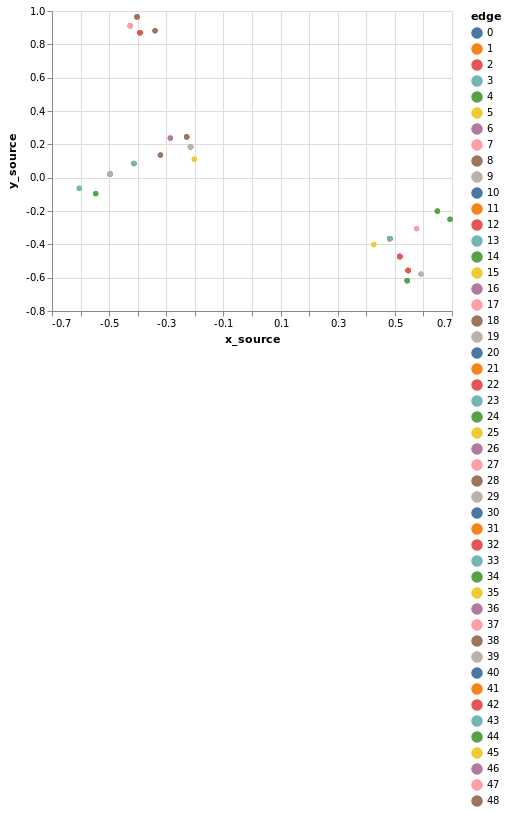

In [19]:
chart = alt.Chart(df_authors).mark_line(point=True).encode(
    x = 'x_source',
    y = 'y_source',
    color='edge:N'
)
chart

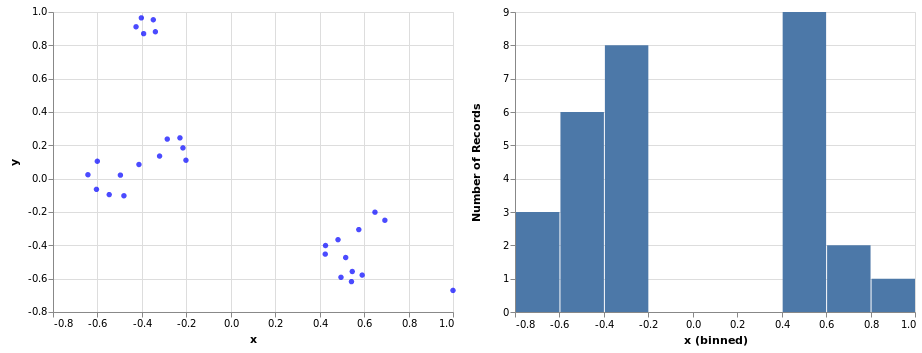

In [27]:
interval = alt.selection_interval(encodings=['x','y'])
interval = alt.selection_multi(encodings=['x','y'])

chart = alt.Chart(df_nodes_authors).mark_circle().encode(
    x = 'x',
    y = 'y',
    color = alt.condition(interval,alt.value('blue'),alt.value('lightgray')),
    tooltip = 'author_name'
).properties(selection=interval)

hist = alt.Chart(df_nodes_authors).mark_bar().encode(
    x = alt.X('x',bin=True),
    y = 'count()'
#     y = alt.Y('y',bin=True),
#     color = 'count()'
).transform_filter(interval)

chart | hist

# chart | chart.encode(x='y')
# alt.vconcat(chart,chart.encode(x='y'))
# chart | chart.encode(x='y')

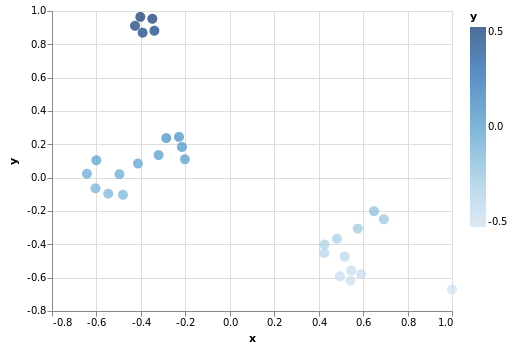

In [21]:
single = alt.selection_single(encodings=['x','y'])

chart = alt.Chart(df_nodes_authors).mark_circle(size=100).encode(
    x = 'x',
    y = 'y',
    color = alt.condition(single,'y',alt.value('lightgray')),
    tooltip = 'author_name'
).properties(selection=single)

chart

In [22]:
df_edges_authors
df_nodes_authors

A = nx.to_pandas_edgelist(G_authors)
A
df_edges_authors
#abs single = alt.selection_single(encodings=['x','y'])

# chart = alt.Chart(df_nodes_authors).mark_circle(size=100).encode(
#     x = 'x',
#     y = 'y',
#     color = alt.condition(single,'y',alt.value('lightgray')),
#     tooltip = 'author_name'
# ).properties(selection=single)

# chart

,source,count,y,target,x,pair,edge
0,1,4,-0.366216,9,0.482571,"(1, 9)",0
1,1,4,-0.305709,9,0.576074,"(1, 9)",0
2,1,6,-0.366216,12,0.482571,"(1, 12)",1
3,1,6,-0.473215,12,0.517109,"(1, 12)",1
4,1,1,-0.366216,23,0.482571,"(1, 23)",2
5,1,1,-0.401232,23,0.426358,"(1, 23)",2
6,1,1,-0.366216,24,0.482571,"(1, 24)",3
7,1,1,-0.452811,24,0.42512,"(1, 24)",3
8,2,1,-0.201169,6,0.648823,"(2, 6)",4
9,2,1,-0.249712,6,0.693324,"(2, 6)",4


In [23]:
nx

<module 'networkx' from '/home/davi/Envs/datascience/lib/python3.6/site-packages/networkx/__init__.py'>